#EmDet

Purpose of this project is to build an NLP model to predict the emotion

## Get Data

In [1]:
!wget https://raw.githubusercontent.com/egehanasal/Emotion-Detection-From-Text/main/data/Cleaned%20Data/emotion_data_cleaned.csv

--2021-10-26 23:08:06--  https://raw.githubusercontent.com/egehanasal/Emotion-Detection-From-Text/main/data/Cleaned%20Data/emotion_data_cleaned.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4226326 (4.0M) [text/plain]
Saving to: ‘emotion_data_cleaned.csv’

emotion_data_cleane 100%[===================>]   4.03M  --.-KB/s    in 0.04s   

2021-10-26 23:08:07 (103 MB/s) - ‘emotion_data_cleaned.csv’ saved [4226326/4226326]



In [2]:
import pandas as pd
df = pd.read_csv("emotion_data_cleaned.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56427 entries, 0 to 56426
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    56334 non-null  object
 1   target  56427 non-null  object
dtypes: object(2)
memory usage: 881.8+ KB


## Preprocess data

In [3]:
import numpy as np
np.where(pd.isnull(df))

(array([  608,  2911,  4446,  4508,  4993,  5876,  6296,  6502,  6806,
         7472,  7918,  8032,  8328,  8984,  9841, 10044, 10076, 10203,
        11079, 12608, 12712, 13738, 13915, 14366, 14461, 15033, 15129,
        16201, 16320, 18421, 18569, 18834, 20199, 20375, 20926, 22303,
        22609, 22684, 22710, 23745, 24038, 24666, 25440, 25590, 25785,
        25921, 26680, 26785, 27405, 27819, 28280, 28303, 29139, 29731,
        29759, 30660, 33759, 33942, 34424, 34693, 35109, 38075, 40378,
        41913, 41975, 42460, 43343, 43763, 43969, 44273, 44939, 45385,
        45499, 45795, 46451, 47308, 47511, 47543, 47670, 48546, 50075,
        50179, 51205, 51382, 51833, 51928, 52500, 52596, 53668, 53787,
        55888, 56036, 56301]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [4]:
np.where(df.applymap(lambda x: x == ''))

(array([], dtype=int64), array([], dtype=int64))

Drop the null lines and check the data again

In [5]:
df.dropna(inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56334 entries, 0 to 56426
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    56334 non-null  object
 1   target  56334 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [7]:
df.head(10)

,text,target
0,Funeral ceremony...gloomy friday...,sadness
1,wants to hang out with friends SOON!,sadness
2,We want to trade with someone who has Houston ...,joy
3,Re-pinging why didn't you go to prom? BC my bf...,neutral
4,"I should be sleep, but im not! thinking about ...",fear
5,Hmmm. is down,sadness
6,Charlene my love. I miss you,fear
7,I'm sorry at least it's Friday?,sadness
8,cant fall asleep,sadness
9,Choked on her retainers,neutral


In [8]:
# Distribution of labels in training data
df.target.value_counts()

joy        16999
fear       10700
sadness    10638
neutral     8626
love        5386
anger       3985
Name: target, dtype: int64

Before splitting our data, let's shuffle it.

In [9]:
# Shuffle the dataframe
df_shuffled = df.sample(frac=1)
df_shuffled.head(10)

,text,target
16724,damn...plans were canceled.....another friday ...,fear
31855,Aiden KNIVES out May 12th www.myspace.com/aide...,sadness
51586,I was supposed to go boating/songwriting in Ca...,sadness
31917,nice one,love
23896,How I Met Your Mother? Best show ever,neutral
11480,No one is bringing snacks,neutral
31484,off to pearlyn's place - gran's bday + mothers...,neutral
49815,i can't i can't i can't i'm sad.... i'm from v...,joy
15588,it's best if i check it while it IS up. when i...,sadness
20879,hope this day will be nice as the sun that are...,joy


### Split the data to train, val and test sets

In [10]:
from sklearn.model_selection import train_test_split
train_sentences, test_sentences, train_labels, test_labels = train_test_split(df_shuffled["text"].to_numpy(),
                                                                          df_shuffled["target"].to_numpy(),
                                                                          test_size=0.15)

In [11]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_sentences,
                                                                        train_labels,
                                                                        test_size=0.1)

In [12]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels), len(test_sentences), len(test_labels)

(43094, 43094, 4789, 4789, 8451, 8451)

In [13]:
# View first 10 lines of training sentences and their labels
train_sentences[:10], train_labels[:10]

(array(['is still missing her husband. I really want him home.',
        "Ugh my neck really hurts I'm out aquatards, xox",
        "Good morning to you, however it's night time for me, so I am off to bed *hugs* Have a great day",
        'hopes whoever stole my purse and money gets what is coming to them',
        'GOSSIP GIRL, WHEN ARE YOU COMING BACK ! chaceeeeeee..',
        'MY CAR IS ALMOST DEFINATELY GOING TO BE WRITTEN OFF! THE GARAGE RANG AND SAID THE WORK WILL COST 3K AND ITS UP TO THE INSURANCE CO',
        'will have to pare down his collection of portraits of and bangbang',
        "I ate to much lunch...now I don't want to work",
        ": i know i*m late but i didn't had internet. so happy bithday to you and pierre!",
        'Today just fucking sucks for me!!'], dtype=object),
 array(['neutral', 'joy', 'love', 'fear', 'anger', 'joy', 'sadness',
        'neutral', 'fear', 'fear'], dtype=object))

## Make numeric labels

We're going to create one hot and label encoded labels.

We could get away with just making label encoded labels, however, TensorFlow's CategoricalCrossentropy loss function likes to have one hot encoded labels 

To numerically encode labels we'll use Scikit-Learn's [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) and [`LabelEncoder`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) classes.



### One hot encode labels

In [14]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_labels.reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_labels.reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_labels.reshape(-1,1))

In [15]:
train_labels_one_hot, train_labels_one_hot.shape

(array([[0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.]]), (43094, 6))

### Label encode labels

In [16]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [17]:
val_labels_encoded, val_labels_encoded.shape

(array([2, 2, 1, ..., 1, 1, 4]), (4789,))

In [18]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(6,
 array(['anger', 'fear', 'joy', 'love', 'neutral', 'sadness'], dtype=object))

## Starting a Series of Modelling Experiments

We've proprocessed our data so now, in true machine learning fashion, it's time to setup a series of modelling experiments.

## Model 0: Getting a baseline

Our first model will be a TF-IDF Multinomial Naive Bayes as recommended by [Scikit-Learn's machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).

To build it, we'll create a Scikit-Learn `Pipeline` which uses the [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) class to convert our abstract sentences to numbers using the TF-IDF (term frequency-inverse document frequecy) algorithm and then learns to classify our sentences using the [`MultinomialNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) aglorithm.

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf_idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(memory=None,
         steps=[('tf_idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [20]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.29525997076633953

In [21]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([2, 4, 2, ..., 2, 2, 2])

### Download helper function script

In [22]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-10-26 23:11:24--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-10-26 23:11:24 (69.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results2(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision*100,
                  "recall": model_recall*100,
                  "f1": model_f1*100}
  return model_results

In [23]:
from helper_functions import calculate_results

In [25]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 29.525997076633953,
 'f1': 0.16023839091061232,
 'precision': 0.20465832344122095,
 'recall': 0.29525997076633953}

## Preparing the data for deep sequence models

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [27]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len 

13.143894741727387

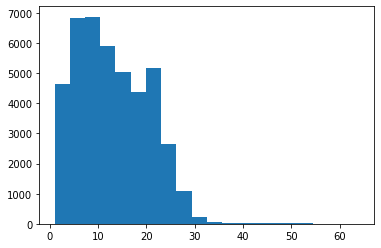

In [30]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

Looks like the vast majority of sentences are between 0 and 50 tokens in length.

We can use NumPy's [`percentile`](https://numpy.org/doc/stable/reference/generated/numpy.percentile.html) to find the value which covers 95% of the sentence lengths.

In [31]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

26

It looks like 95% of the sentences in our training set have a length of 26 tokens or less.

When we create our tokenization layer, we'll use this value to turn all of our sentences into the same length. Meaning sentences with a length below 26 get padded with zeros and sentences with a length above 26 get truncated (words after 26 get cut off).

## Create text vectorizer layer

To do so, we'll use the [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) layer from TensorFlow.

We'll keep all the parameters default except for `max_tokens` (the number of unique words in our dataset) and `output_sequence_length` (our desired output length for each vectorized sentence).

In [32]:
# How many words are in our vocab?
from collections import Counter
results = Counter()
df["text"].str.lower().str.split().apply(results.update)
len(results)

52478

In [33]:
max_tokens = 52450

In [34]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)

In [35]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [36]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"Length of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
she could have been a lost dog poor girl
Length of text: 9

Vectorized text:
[[129 126  18  93   5 238 442 258 235   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]]


In [37]:
# How many words in our training vocabulary
text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(text_vocab)}")
print(f"Most common words in vocab: {text_vocab[:5]}")
print(f"Least common words in vocab: {text_vocab[-5:]}")

Number of words in vocab: 30979
Most common words in vocab: ['', '[UNK]', 'i', 'to', 'the']
Least common words in vocab: ['050809', '0405', '0128', '002', '0003']


In [38]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 52450,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 26,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True}

In [86]:
# Create custom text embedding
token_embed = layers.Embedding(input_dim=len(text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding")

In [40]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentece after vectorization (before the embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentece after embedding: {embedded_sentence}\n")
print(f"Embedded sentece shape: {embedded_sentence.shape}")

Sentence before vectorization:
she could have been a lost dog poor girl

Sentece after vectorization (before the embedding):
[[129 126  18  93   5 238 442 258 235   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]]

Sentece after embedding: [[[ 0.03173027 -0.01559976  0.03681542 ... -0.02692878 -0.03425299
   -0.03108492]
  [ 0.04283258  0.007278    0.02346243 ... -0.01573937  0.04494167
   -0.00732989]
  [ 0.03748336 -0.0249019  -0.04101027 ...  0.01040881 -0.02549201
    0.01156831]
  ...
  [ 0.03378799  0.01039431 -0.04368934 ...  0.03934186 -0.01143274
    0.00161328]
  [ 0.03378799  0.01039431 -0.04368934 ...  0.03934186 -0.01143274
    0.00161328]
  [ 0.03378799  0.01039431 -0.04368934 ...  0.03934186 -0.01143274
    0.00161328]]]

Embedded sentece shape: (1, 26, 128)


## Creating datasets (making sure our data loads as fast as possible)

The main steps we'll want to use with our data is to turn it into a `PrefetchDataset` of batches.

Doing so we'll ensure TensorFlow loads our data onto the GPU as fast as possible, in turn leading to faster training time.

To create a batched `PrefetchDataset` we can use the methods [`batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch), the parameter [`tf.data.AUTOTUNE`](https://www.tensorflow.org/api_docs/python/tf/data#AUTOTUNE) will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets.

In [75]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (6,)), types: (tf.string, tf.float64)>

In [76]:
# Take the TensorSliceDataset's and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 6)), types: (tf.string, tf.float64)>

## Model 1: Conv1D with token embeddings

In [87]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(16, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.MaxPooling1D(pool_size=2, padding="valid")(x)
x = layers.Dropout(0.5)(x)
x = layers.MaxPooling1D(pool_size=2, padding="valid")(x)
x = layers.Dropout(0.6)(x)
x = layers.MaxPooling1D(pool_size=3, padding="valid")(x)
x = layers.GlobalAveragePooling1D()(x)  #condense the output of our vector from conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

In [88]:
# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [89]:
# Get a summary of the model
model_1.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 26)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 26, 128)           3965312   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 26, 16)            10256     
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 13, 16)            0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 13, 16)            0         
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 6, 16)             0   

In [90]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              epochs=3,
                              validation_data=val_dataset)

Epoch 1/3
1347/1347 [==============================] - 14s 10ms/step - loss: 1.6992 - accuracy: 0.2978 - val_loss: 1.7104 - val_accuracy: 0.2982
Epoch 2/3
1347/1347 [==============================] - 13s 10ms/step - loss: 1.6688 - accuracy: 0.3070 - val_loss: 1.6966 - val_accuracy: 0.2955
Epoch 3/3
1347/1347 [==============================] - 13s 10ms/step - loss: 1.6264 - accuracy: 0.3278 - val_loss: 1.6961 - val_accuracy: 0.2930


In [91]:
model_1.evaluate(test_dataset)

265/265 [==============================] - 1s 4ms/step - loss: 1.6895 - accuracy: 0.2933


[1.6895335912704468, 0.2933380603790283]